In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib notebook

# Load mavenn and check path
import mavenn

# Other imports
from matplotlib.gridspec import GridSpec

# Import helper functions
from helper_functions import my_rsquared, save_fig_with_date_stamp, set_xticks

# Set random seed
np.random.seed(0)

# Set figure name
fig_name = 'fig4'

In [2]:
style_file_name = f'{fig_name}.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)
plt.rc('font', family='sans-serif')
plt.rc('font', family='sans-serif')

In [3]:
def draw(model_file,
         dataset_file,
         phi_lim,
         theta_ax,
         ge_ax,
         pos_start,
         pos_spacing,
         scatter_alpha,
         text_x,
         text_y,
         phi_ticks,
         yticks,
         ylim):
    '''Draws Fig. 4 panels'''

    # Load model
    print(f'Loading model from {model_file} ...')
    model = mavenn.load(model_file)
    
    # Load dataset
    print(f'Loading dataset from {dataset_file} ...')
    data_df = pd.read_csv(dataset_file)
    
    # Get indices for aa order used in Seuma et al. and Bolognesi et al.
    alphabet = np.array(list('GAVLMIFYWKRDESTCNQHP*'))
    aix = alphabet[:-1].argsort()
    sorted_aa = alphabet[aix]
    aixx = aix.argsort()
    sorted_aa[aixx]
    aixx = np.append(aixx,int(20))
    aixx
    
    # Get a bunch of parameters
    theta_lc = model.get_theta()['theta_lc'][:,aixx]
    alphabet = model.alphabet[aixx]
    wt_seq = model.x_stats['consensus_seq']
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
    yhat_grid = model.phi_to_yhat(phi_grid)
    yq_grid = model.yhat_to_yq(yhat_grid, q=[0.025, 0.975])              
    test_ix = (data_df['set']=='test')
    x_test = data_df['x'][test_ix].values
    phi_test = model.x_to_phi(x_test)
    yhat_test = model.phi_to_yhat(phi_test)
    y_test = data_df['y'][test_ix].values
    r2, dr2 = my_rsquared(yhat_test, y_test) 
    I_var, dI_var = model.I_variational(x_test, y_test)
    I_pred, dI_pred = model.I_predictive(x_test, y_test)
    
    #
    # Heatmap panel
    #
    
    # Show parameter heatmap
    ax = theta_ax
    _, cb = mavenn.heatmap(theta_lc, 
                           alphabet=alphabet,
                           ax=ax, 
                           seq=wt_seq, 
                           seq_kwargs={'s':3, 'color':'gray'},
                           ccenter=0,
                           cmap_size="2%",
                           cmap='coolwarm')


    # Print number of total and undetermined parameters
    num_nan = (~np.isfinite(theta_lc)).sum().sum()
    num_tot = len(theta_lc.ravel())
    pct_nan = 100*num_nan/num_tot
    print(f'{num_nan}/{num_tot} ({pct_nan:.1f}%) are undetermined.')

    
    # Style axes
    set_xticks(ax=ax, L=len(theta_lc), pos_start=pos_start, pos_spacing=pos_spacing)
    ax.set_ylabel('amino acid')
    ax.set_xlabel('position')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(rotation=0, size=2)
    ax.tick_params(axis='y', size=0, pad=6, labelsize=6)
    cb.outline.set_visible(False)
    cb.ax.tick_params(direction='in', size=10, color='white')
    # cb.set_ticks([-2, -1.5, -.5, 0, .5, 1.0])
    cb.set_label('additive effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

    #
    # GE plot panel 
    #
    ax = ge_ax
    
    # Draw scatter plot
    ax.scatter(phi_test, 
               y_test, 
               s=2,
               alpha=scatter_alpha,
               color='C0',
               label='test data')
    
    # Draw curves
    ax.plot(phi_grid, yhat_grid,    color='C1',  alpha=1, linewidth=2, linestyle='-', label='$\hat{y}$')
    ax.plot(phi_grid, yq_grid[:,0], color='C1', alpha=1, linewidth=1, linestyle=':',  label='95% CI')
    ax.plot(phi_grid, yq_grid[:,1], color='C1', alpha=1, linewidth=1,linestyle=':')

    # Draw wt phi
    phi_wt = model.x_to_phi(wt_seq)
    ax.axvline(phi_wt, color='lightgray', zorder=-1)
    
    # Annotate Rsq
    ax.text(x=text_x, y=text_y, fontsize=6.5, ha='left', va='top',
            s=f'$I_{{\\rm var}}$: {I_var:.3f} $\pm$ {dI_var:.3f} bits\n' +
              f'$I_{{\\rm pre}}$: {I_pred:.3f} $\pm$ {dI_pred:.3f} bits\n' +
              f'$R^2$: {r2:.3f} $\pm$ {dr2:.3f}');
    
    # Style axes
    ax.set_xticks(phi_ticks)
    ax.set_yticks(yticks)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('nucleation score ($y$)', labelpad=-1)
    ax.set_xlim(phi_lim)
    ax.set_ylim(ylim)
    #ax.set_xlim(xlim)


<IPython.core.display.Javascript object>


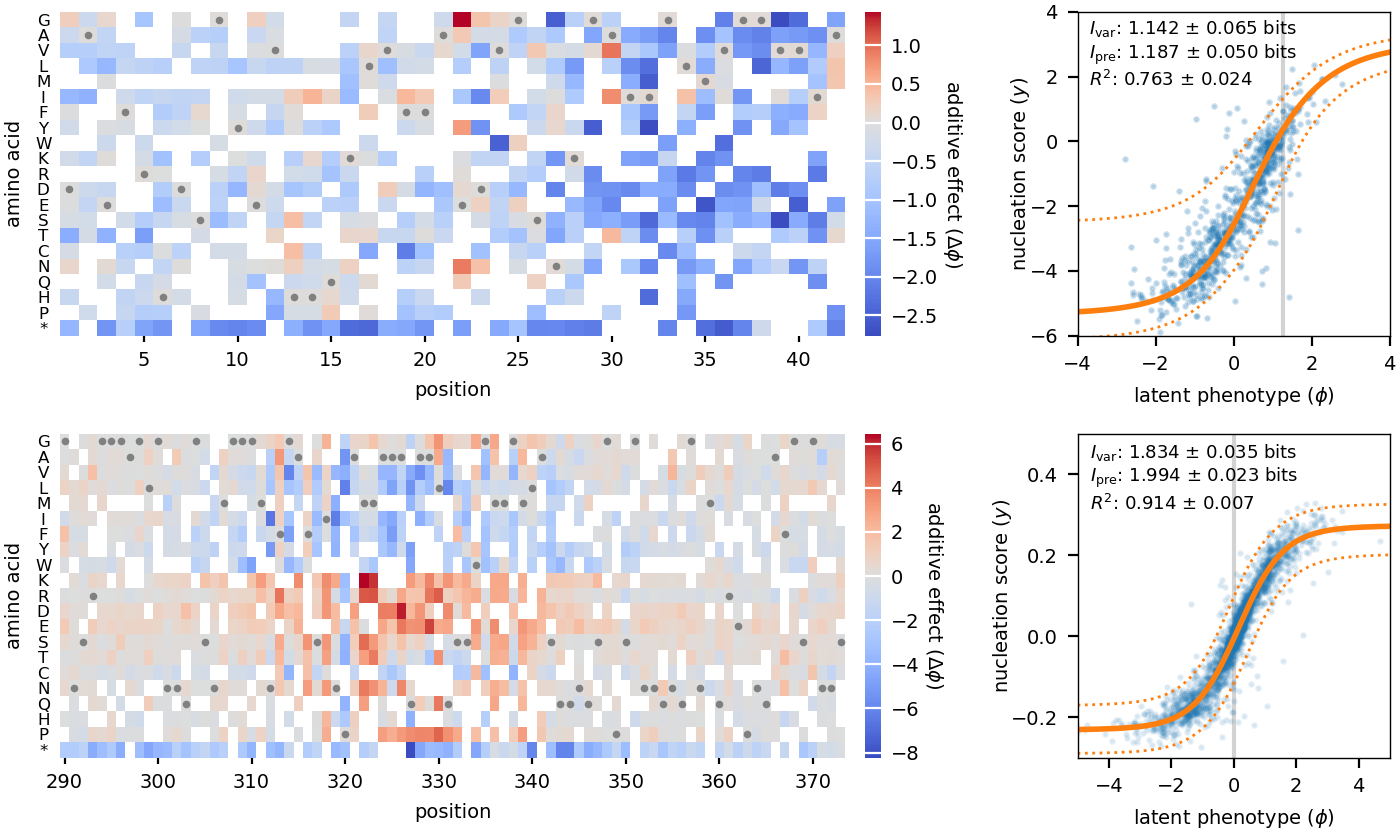

Computing and drawing results for amyloid beta...
Loading model from ../models/amyloid_ge_additive_2021.12.30.21h.07m ...
Model loaded from these files:
	../models/amyloid_ge_additive_2021.12.30.21h.07m.pickle
	../models/amyloid_ge_additive_2021.12.30.21h.07m.h5
Loading dataset from ../datasets/amyloid_data.csv.gz ...
355/882 (40.2%) are undetermined.
Computing and drawing results for TDP-43
Loading model from ../models/tdp43_ge_additive_2021.12.30.21h.07m ...
Model loaded from these files:
	../models/tdp43_ge_additive_2021.12.30.21h.07m.pickle
	../models/tdp43_ge_additive_2021.12.30.21h.07m.h5
Loading dataset from ../datasets/tdp43_data.csv.gz ...
433/1764 (24.5%) are undetermined.
Figure saved figure to png/fig4_ipynb_2021.12.31.14h.18m.56s.png.


In [4]:
fig = plt.figure(figsize=[7.0, 4.20])

plt.style.use(style_file_name)
gs = fig.add_gridspec(2, 3)
# Define panels
ax_a = fig.add_subplot(gs[0, 0:2])
ax_b = fig.add_subplot(gs[0, 2])
ax_c = fig.add_subplot(gs[1, 0:2])
ax_d = fig.add_subplot(gs[1, 2])

alpha = 0.1

# Draw results for amyloid beta
print('Computing and drawing results for amyloid beta...')
draw(model_file='../models/amyloid_ge_additive_2021.12.30.21h.07m',
     dataset_file='../datasets/amyloid_data.csv.gz',
     phi_lim=[-4,4],
     theta_ax=ax_a,
     ge_ax=ax_b,
     pos_start=1,
     pos_spacing=5,
     scatter_alpha=.2,
     text_x=-3.7,
     text_y=3.8,
     phi_ticks = [-4,-2,0,2,4],
     yticks = [-6,-4,-2,0,2,4],
     ylim = [-6, 4]
)

# Draw results for TDP-43
print('Computing and drawing results for TDP-43')
draw(model_file='../models/tdp43_ge_additive_2021.12.30.21h.07m',
     dataset_file='../datasets/tdp43_data.csv.gz',
     phi_lim=[-5,5],
     theta_ax=ax_c,
     ge_ax=ax_d,
     pos_start=290,
     pos_spacing=10,
     scatter_alpha=.1,
     text_x=-4.6,
     text_y=0.48,
     phi_ticks = [-4,-2,0,2,4],
     yticks = [-0.2,0.0,0.2,0.4],
     ylim = [-0.3, 0.5]
)

# Tighten figure
fig.tight_layout(h_pad=1, w_pad=2, pad=.2)
            
# Save figure
save_fig_with_date_stamp(fig, fig_name)